# Reinforcement Learning with Continuous Control
# Report :

# 1 Learning on a single agent


## 1.1 DDPG
cf [Continuous_Control_Single_Agent_DDPG_baseline](https://github.com/kossowski-pierre/RL_continuous_control/blob/main/Continuous_Control_Single_Agent_DDPG_baseline.ipynb)

### HyperParameters : 
`BATCH_SIZE = 128        # minibatch size`<br>
`GAMMA = 0.99            # discount factor`<br>
`TAU = 1e-3              # for soft update of target parameters`<br>
`LR_ACTOR = 1e-4         # learning rate of the actor `<br>
`LR_CRITIC = 1e-4        # learning rate of the critic`<br>
`WEIGHT_DECAY = 0.0   # L2 weight decay`<br>


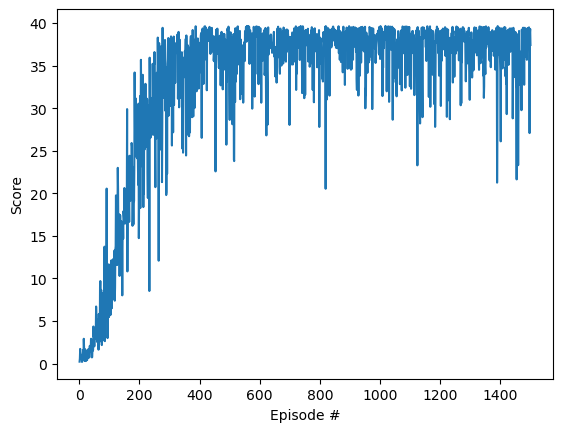

solved in **320** episodes (episodes 220 to 320 have an average score above 30)

## 1.2 PPO with GAE
cf [Continuous_Control_Single_Agent_PPO_GAE](https://github.com/kossowski-pierre/RL_continuous_control/blob/main/Continuous_Control_Single_Agent_PPO_GAE.ipynb)

### HyperParameters : 
`BATCH_SIZE = 512        # minibatch size`<br>
`GAMMA = 0.98            # discount factor`<br>
`TAU = 1e-3              # for soft update of target parameters`<br>
`LR_ACTOR = 1e-4         # learning rate of the actor `<br>
`LR_CRITIC = 1e-4        # learning rate of the critic`<br>
`WEIGHT_DECAY = 0.0001   # L2 weight decay`<br>
`NUM_EPOCHS = 20`<br>
`LAMBDA=0.5              # GAE parameter`<br>
`epsilon=0.3`<br>
`entropy_coef=0.001`

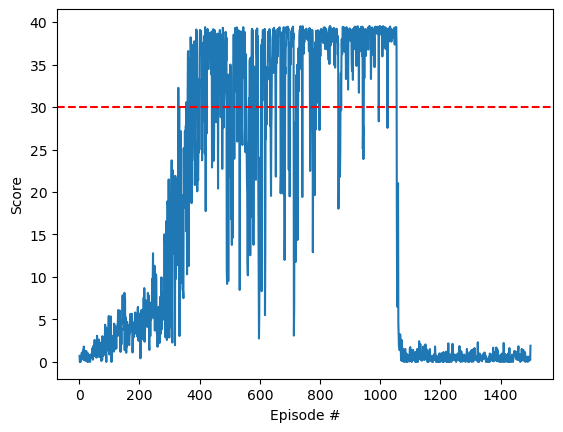

-->solved in **440 episodes** (episodes 340 to 440 have a mean score up to 30)

**note:** We observe a sudden drop in performance around episode 1000. This happened often in our early implementations of PPO with GAE. We suspect entropy loss to be responsible.
By decreasing, the entropy loss increases the standard deviation of the actor distribution: and we observe that a too high standard deviation can stop the training of the actor model.<br><br>
      So we decided to follow the **standard derivation of the actor distribution** to help us tune our hyperparameters (especially the entropy coefficient).<br> --> We want to penalize low variance but having too much variance can stop learning. <br>
As a result :
- We decrease our "**entropy_coef**" hyperparameter from 0.01 to 0.001<br>
- We also use gradient clipping when training the actor network (to limit the sudden increase in variance).
- LAMBDA hyperparameter is also scaled down (from 0.9 to 0.5) to reduce the variance from the Generalized Benefit Estimate (GAE)

# 2 Learning on 20 parallel agents

## 2.1 DDPG
cf [Continuous_Control_20_parallel_agents_DDPG](https://github.com/kossowski-pierre/RL_continuous_control/blob/main/Continuous_Control_20_parallel_agents_DDPG.ipynb)

### Hyper parameters :

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99           # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0   # L2 weight decay

### Actor Critic Models :

In [ ]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_units (int): Number of nodes in hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        return F.tanh(self.fc2(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)


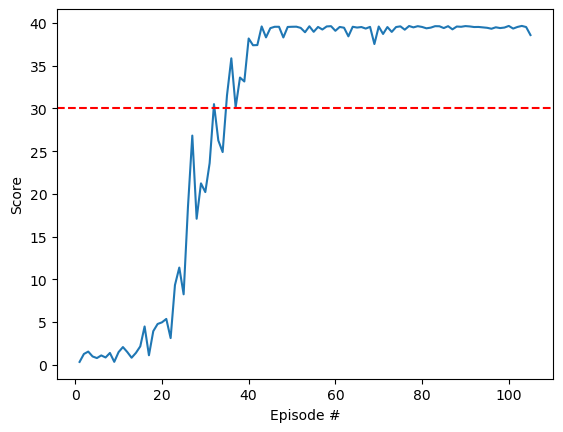


Solved in **105** episodes (episodes 5 to 105 have an average score above 30)

## 2.2 PPO with GAE
cf. [Continuous_Control_20_parallel_agents_PPO_with_GAE_FINAL_MODEL](https://github.com/kossowski-pierre/RL_continuous_control/blob/main/Continuous_Control_20_parallel_agents_PPO_with_GAE_FINAL_MODEL.ipynb)

### 2.2.1 First implementation :

#### Hyper parameters : 

`BATCH_SIZE = 256        # minibatch size`<br>
`GAMMA = 0.97            # discount factor`<br>
`TAU = 1e-3              # for soft update of target parameters`<br>
`LR_ACTOR = 1e-4         # learning rate of the actor `<br>
`LR_CRITIC = 3e-4        # learning rate of the critic`<br>
`WEIGHT_DECAY = 0.0001   # L2 weight decay`<br>
`NUM_EPOCHS = 20`<br>
`SEED=47`<br>
`LAMBDA=0.5              # GAE parameter`<br>
`epsilon=0.2             # clip PPO loss`<br>
`entropy_coef=0.001      # weighted entropy loss`<br>

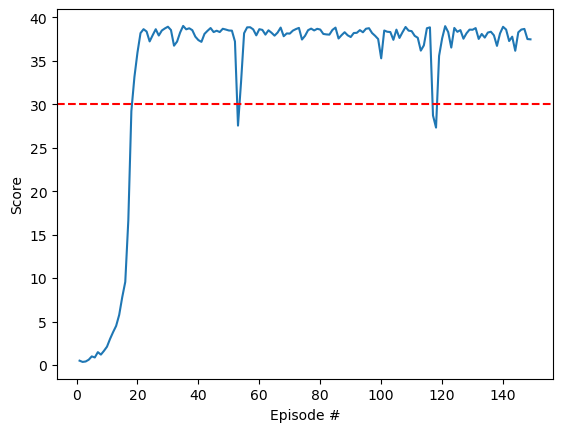

solved in **114** episodes (episodes 14 to 114 have an average score above 30)

### 2.2.2 Second implementation (variante)
Finally, we train a [second PPO model](https://github.com/kossowski-pierre/RL_continuous_control/blob/main/Continuous_Control_20_parallel_agents_PPO_with_GAE_FINAL_MODEL.ipynb) (with 20 parallel agents) with some modifications. 


In this implementation of PPO, we took advice from our previous implementations and made some improvements : 
- We add a third dense Layer to the Actor model
- Weights are updating every 160 steps (previously, we were waiting the end of the episode to update ours networks)
- we tried to stabilize the learning by **modifying** the standard derivation of **the actor model :**
     
     - **The std range is reduced**  (because we observed when the variance was too high (>2), the model stop to learn).So the range of Std is passed from `[np.exp(-1), np.exp(1)]` to `[(np.exp(-1)-0.3)/2, (np.exp(1)-0.3)/2]`.
     - Std is now simply learn from independant parameters (sigma is now independent of state and mu) (*this doesn't seems to impact our performances*)

This will be our best model: 

### Hyper Parameters :

In [ ]:
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.97            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0001   # L2 weight decay
NUM_EPOCHS = 20
SEED=47
LAMBDA=0.5              # GAE parameter
epsilon=0.2
entropy_coef=0.03      <br>

In [ ]:
class Actor_PPO(nn.Module):
    def __init__(self,state_size, action_size, size1=64*4,size2=64*4,size3=32*4, seed=SEED):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            size1 (int): Number of nodes in first hidden layer
            size2 (int): Number of nodes in second hidden layer
            size3 (int): Number of nodes in third hidden layer
        """
        super(Actor_PPO, self).__init__()
        self.seed=torch.manual_seed(seed)
        self.state_size = state_size
        self.action_size = action_size
        self.dense1 = nn.Linear(state_size, size1)
        self.dense2=nn.Linear(size1, size2)
        self.dense3=nn.Linear(size2, size3)
        self.linear_mu=nn.Linear(size3, action_size)
        self.linear_log_sigma=nn.Parameter(torch.zeros(action_size))# sigma is learned independantly from state and mu
    
    def reset_parameters(self):
        self.dense1.weight.data.uniform_(*hidden_init(self.dense1))
        self.dense2.weight.data.uniform_(*hidden_init(self.dense2))
        self.dense3.weight.data.uniform_(*hidden_init(self.dense3))
        self.linear_mu.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, x):
        mu,sigma = self.get_params(x)
        distribution = torch.distributions.normal.Normal(mu,sigma)
        self.mu = mu
        self.sigma=sigma
        action = distribution.sample()
        return action, distribution
    
    def get_params(self, x_state):
        xs=self.dense1(x_state)
        xs=F.relu(xs)
        x=self.dense2(xs)
        x=F.relu(x)
        x=self.dense3(x)
        x=F.relu(x)
        mu=F.tanh(self.linear_mu(x))
        log_sigma = F.tanh(self.linear_log_sigma)
        sigma = (torch.exp(log_sigma)-0.3)/2     # sigma range reduced
        return(mu,sigma)
    
    
    
class Critic_PPO(nn.Module):
    def __init__(self,state_size,size1=256,size2=128*2,size3=64*2, seed=SEED):
        super(Critic_PPO, self).__init__()
        self.seed=torch.manual_seed(seed)
        self.state_size = state_size
        self.dense1=nn.Linear(state_size, size1,bias=False)
        self.dense2=nn.Linear(size1, size2,bias=False)
        self.dense3=nn.Linear(size2, size3,bias=False)
        self.dense4=nn.Linear(size3, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.dense1.weight.data.uniform_(*hidden_init(self.dense1))
        self.dense2.weight.data.uniform_(*hidden_init(self.dense2))
        self.dense3.weight.data.uniform_(*hidden_init(self.dense3))
        self.dense4.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = self.dense1(state)
        x = F.leaky_relu(x)
        x = self.dense2(x)
        x = F.leaky_relu(x)
        x = self.dense3(x)
        x = F.leaky_relu(x)
        x = self.dense4(x)
        return x

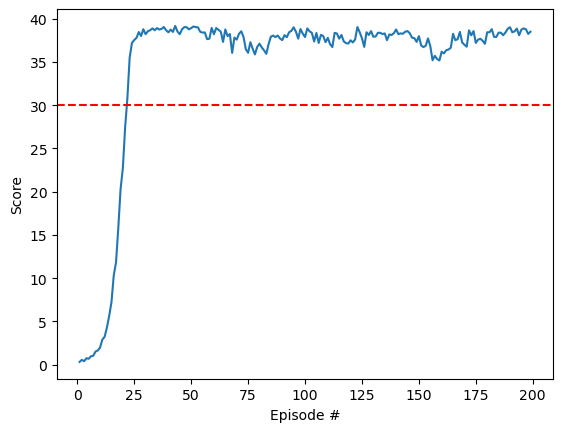

Solves in **83** episodes (episodes 0 to 83 have an average score above 30)

# Conclusion : 
We have implement two architectures : [DDPG](https://arxiv.org/pdf/1509.02971v6.pdf) and [PPO](https://arxiv.org/pdf/1707.06347.pdf) with [GAE](https://arxiv.org/pdf/1506.02438.pdf)<br>
As expected, training on 20 parallel agent is more stable and efficient than with single agent.<br>

About algorithms, DDPG was more stable and easier to train than PPO.<br>
With PPO, the entropy_coefficient was a crucial hyper parameter. We decided to track the Actor model **standard deviation** during training to re-adjust this coefficient if necessary.<br>
Finaly, we were able to solved this environement with both approachs.<br>

**note:** We also tried to use **batch normalization** in both PPO and DDPG models but it did not improve our performances here.<br>
## For further :


We could implement [DD4PG](https://arxiv.org/pdf/1804.08617v1.pdf) or [A3C](https://arxiv.org/pdf/1602.01783.pdf)<br>
We also could improve our PPO implementation with [PPO with Continuous Bounded Action Space
via the Beta Distribution](https://arxiv.org/pdf/2111.02202.pdf)<br>
Another approach I would like to test with continuous action space is [PL-LS](https://arxiv.org/pdf/2211.13257.pdf) with PPO<br>